## Mapaton2023 Categoria 4 
### EspiritusMaquina


![:o](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKqyWbTjGDl4toc-aKgAYbzkS9GQC4eoIPxFfVQ9azUshTOntx0j5d4utiBFTp6AwJJ88&usqp=CAU)


## Carga de datos

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout,Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import load_model

# Cargar el dataset de entrenamiento
data_folder = "./Dataset"
# data_folder = "./DatasetPeruSat1"
# cargar imagenes de entrenamiento
image_folder = os.path.join(data_folder, "train_images_256")
#cargar mascaras de entrenamiento
mask_folder = os.path.join(data_folder, "train_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

print("Numero de Imagenes de entrenamiento: ", len(image_files))
print("Numero de Mascaras de entrenamiento: ", len(os.listdir(mask_folder)))


2023-07-31 21:27:43.513353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 21:27:44.607485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Numero de Imagenes de entrenamiento:  790
Numero de Mascaras de entrenamiento:  790


## Preprocesamiento de Datos

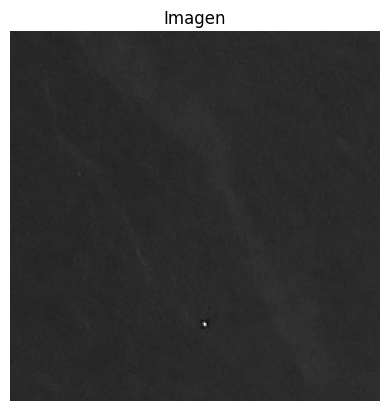

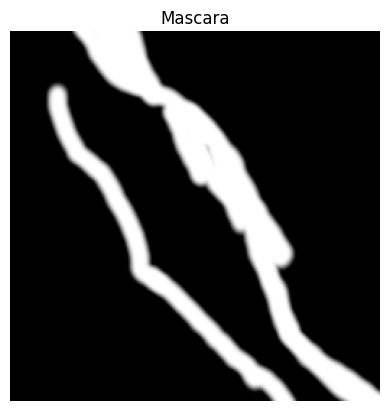

In [2]:

# Redimensionar todas las imágenes a un tamaño específico
image_size = (256, 256)

# listas para almacenar las imágenes y sus máscaras
images = []
masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, image_size)
    mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    images.append(image)
    masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
images = np.array(images)
masks = np.array(masks)


# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)




# plotear una imagen y su máscara de ejemplo
def plotImage (image,title):
    image = cv2.imread( image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

    
#imagen
plotImage("./DatasetPeruSat1/train_images_256/20220123_corte3_part11.tiff","Imagen")

#mascara
plotImage("./DatasetPeruSat1/train_masks_256/20220123_corte3_part11.tiff","Mascara")




## Arquitectura de Red Neuronal Convolucional: U-net

In [3]:


def unet(input_layer=(256, 256, 1), start_neurons=16):
    inputs = Input(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=inputs, outputs=output_layer)
    
    return model



## Carga y Entrenamiento del modelo
- save =  para entrenar por primera vez
- load = para cargar un modelo pre-entrenado
- reinforce = cargar el modelo pre-entrenado y reforzar el aprendizaje

2023-07-31 21:28:21.509163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 21:28:21.954963: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


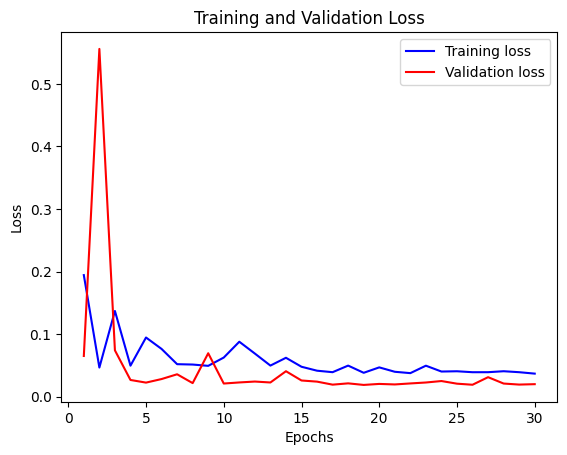

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [4]:
import json

# definir el tipo de operacion a realizar
# save = entrenar y guardar el modelo
# load = cargar el modelo pre-entrenado
# reinforce = cargar el modelo pre-entrenado y reforzar el aprendizaje
save_load = "load"

#nombre del modelo pre-entrenado
model_name = "model_100E_32N_reinforce_E30.h5"
# model_name = "model_100E_32N_reinforce_E30.h5"

#definir el numero de neuronas y epocas
neuronas = 16
epocas = 10

#modelo de la red
model  = None
history = None

if save_load == "save":
    model = unet(input_layer=(256,256,1), start_neurons=neuronas)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(images, masks, batch_size=8, epochs=epocas, validation_split=0.2)
    model.save("./DataSave/models/" + model_name )
elif save_load == "reinforce":
    #cargar el modelo pre-entrenado
    model = tf.keras.models.load_model("./DataSave/models/" + model_name)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #refuerzo de aprensizaje con otro dataset
    history = model.fit(images, masks, batch_size=8, epochs=epocas, validation_split=0.2)

    #Guardar el modelo en un archivo H5
    file_name = model_name[:-3] + "_reinforce_E" + str(epocas) +".h5"
    model.save("./DataSave/models/" + file_name)
    #Guardar el historial en un archivo JSON
    history_path = "./DataSave/data/" + file_name + ".json"
    with open(history_path, 'w') as json_file:
        json.dump(history.history, json_file)
else:
    #Cargar el modelo pre-entrenado
    model = tf.keras.models.load_model("./DataSave/models/" + model_name)

    # Leer el archivo JSON que contiene el historial de entrenamiento
    history_path = os.path.join("./DataSave/data/", model_name + ".json")
    if os.path.exists(history_path):
        with open(history_path, 'r') as json_file:
            history_data = json.load(json_file)
        # Extraer las métricas de entrenamiento y validación del historial
        loss = history_data['loss']
        val_loss = history_data['val_loss']
        # Crear un gráfico para mostrar la pérdida por época
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

#plot de caracteristicas
print("Caracteristicas del Modelo: ", model.summary())


## Test de Modelos


- Se realiza una comparación con los modelos pre-entrenados con imagenes :
    - Satelitales Sentinel de distintos derrames en el mundo
    - PeruSat-1 del derrame de Ventanilla en Perú

In [5]:

model_SAR_name = "model_100E_32N.h5"
model_PER1_name = "model_200E_30N_perusat.h5"

#modelos reforzados
model_SAR_PER1_name = "model_100E_32N_reinforce_E30.h5"
model_PER1_SAR_name = "model_200E_30N_perusat_reinforce_E35.h5"


# Cargar los modelos pre-entrenados 
model_SAR = tf.keras.models.load_model("./DataSave/models/" + model_SAR_name)
model_PER1 = tf.keras.models.load_model("./DataSave/models/" + model_PER1_name)
model_SAR_PER1 = tf.keras.models.load_model("./DataSave/models/" + model_SAR_PER1_name)
model_PER1_SAR = tf.keras.models.load_model("./DataSave/models/" + model_PER1_SAR_name)


# Cargar el dataset de entrenamiento
data_folder = "./DatasetPeruSat1"
# cargar imagenes de entrenamiento
image_folder = os.path.join(data_folder, "test_images_256")
#cargar mascaras de entrenamiento
mask_folder = os.path.join(data_folder, "test_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

# listas para almacenar las imágenes y sus máscaras0
test_images = []
test_masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, image_size)
    mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    test_images.append(image)
    test_masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
test_images = np.array(test_images)
test_masks = np.array(test_masks)


# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

print("Numero de Imagenes de entrenamiento: ", len(test_images))
print("Numero de Mascaras de entrenamiento: ", len(test_masks))


# Realizar predicciones con ambos modelos en el conjunto de prueba
predictions_model_SAR = model_SAR.predict(test_images)
predictions_model_PER1 = model_PER1.predict(test_images)
predictions_model_SAR_PER1 = model_SAR_PER1.predict(test_images)
predictions_model_PER1_SAR = model_PER1_SAR.predict(test_images)

Numero de Imagenes de entrenamiento:  132
Numero de Mascaras de entrenamiento:  132


2023-07-31 21:28:31.094852: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


1/5 [=====>........................] - ETA: 9s

2023-07-31 21:28:33.136334: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


2/5 [===========>..................] - ETA: 6s

2023-07-31 21:28:35.158323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


3/5 [=================>............] - ETA: 4s

2023-07-31 21:28:37.178047: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


5/5 [==============================] - 8s 2s/step


2023-07-31 21:28:48.342024: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 536870912 exceeds 10% of free system memory.


5/5 [==============================] - 9s 2s/step


SAR
F1-score Micro Model SAR: 0.0167003319186295
F1-score Macro Model SAR: 0.011737073053854161
PER1
F1-score Micro Model PER1: 0.25720844848577534
F1-score Macro Model PER1: 0.1797820574883507
SAR_PER1
F1-score Micro Model SAR_PER1: 0.25756081917704193
F1-score Macro Model SAR_PER1: 0.17973066783597394
PER1_SAR
F1-score Micro Model SAR_PER1: 0.009509749936580436
F1-score Macro Model SAR_PER1: 0.005547963431872685


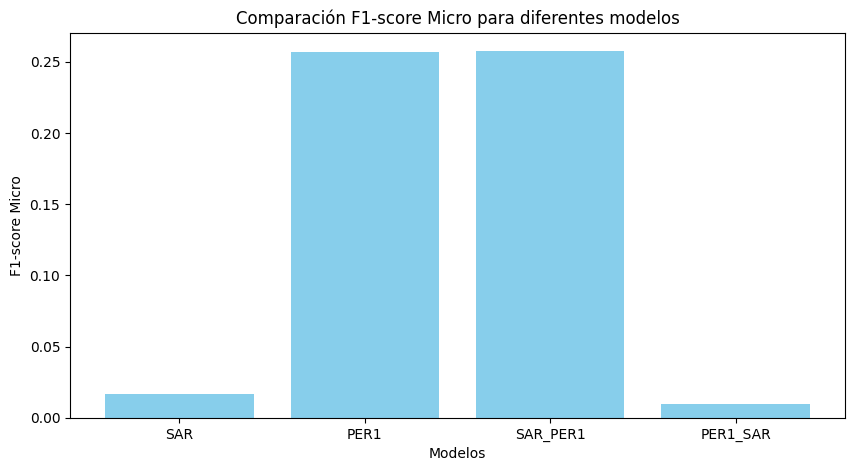

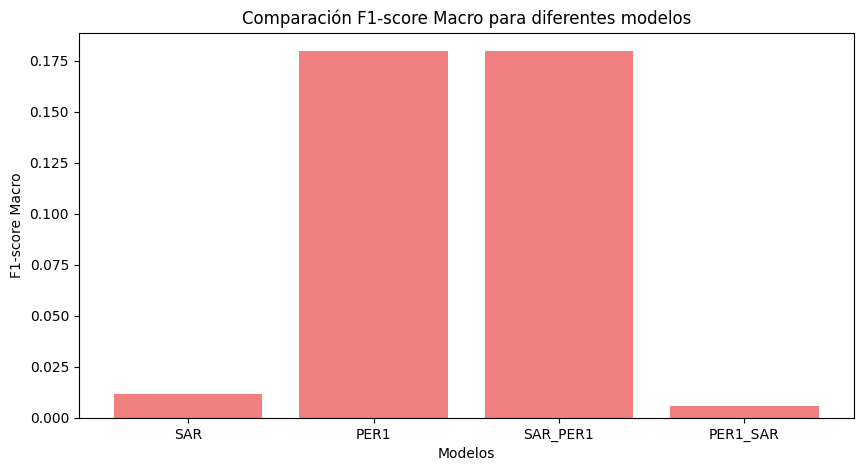

In [6]:
def calculate_f1_micro_macro(mask_true, mask_pred):
    TP_micro = 0
    FP_micro = 0
    FN_micro = 0
    total_f1_score_macro = 0

    for i in range(mask_true.shape[0]):
        TP_macro = 0
        FP_macro = 0
        FN_macro = 0

        image_true = mask_true[i, :, :, 0]
        image_pred = mask_pred[i, :, :, 0]

        for j in range(len(image_true)):
            for k in range(len(image_true[0])):
                if image_true[j][k] > 0.0 and image_pred[j][k] > 0.00015068304:
                    TP_micro += 1
                    TP_macro += 1
                elif image_true[j][k] == 0.0 and image_pred[j][k] > 0.00015068304:
                    FP_micro += 1
                    FP_macro += 1
                elif image_true[j][k] > 0.0 and image_pred[j][k] <= 0.00015068304:
                    FN_micro += 1
                    FN_macro += 1

        precision_macro = TP_macro / (TP_macro + FP_macro + 1e-9)
        recall_macro = TP_macro / (TP_macro + FN_macro + 1e-9)
        f1_score_macro = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro + 1e-9)

        total_f1_score_macro += f1_score_macro

    precision_micro = TP_micro / (TP_micro + FP_micro + 1e-9)
    recall_micro = TP_micro / (TP_micro + FN_micro + 1e-9)
    f1_score_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro + 1e-9)

    macro_f1_score = total_f1_score_macro / mask_true.shape[0]

    return f1_score_micro, macro_f1_score


f1_micro_model_SAR, f1_macro_model_SAR = calculate_f1_micro_macro(test_masks, predictions_model_SAR)
f1_micro_model_PER1, f1_macro_model_PER1 = calculate_f1_micro_macro(test_masks, predictions_model_PER1)
f1_micro_model_SAR_PER1, f1_macro_model_SAR_PER1 = calculate_f1_micro_macro(test_masks, predictions_model_SAR_PER1)
f1_micro_model_PER1_SAR, f1_macro_model_PER1_SAR = calculate_f1_micro_macro(test_masks, predictions_model_PER1_SAR)


print("SAR")
print("F1-score Micro Model SAR:", f1_micro_model_SAR)
print("F1-score Macro Model SAR:", f1_macro_model_SAR)

print("PER1")
print("F1-score Micro Model PER1:", f1_micro_model_PER1)
print("F1-score Macro Model PER1:", f1_macro_model_PER1)

print("SAR_PER1")
print("F1-score Micro Model SAR_PER1:", f1_micro_model_SAR_PER1)
print("F1-score Macro Model SAR_PER1:", f1_macro_model_SAR_PER1)

print("PER1_SAR")
print("F1-score Micro Model SAR_PER1:", f1_micro_model_PER1_SAR)
print("F1-score Macro Model SAR_PER1:", f1_macro_model_PER1_SAR)



# Datos de ejemplo para SAR, PER1, SAR_PER1 y PER1_SAR
modelos = ['SAR', 'PER1', 'SAR_PER1', 'PER1_SAR']
f1_micro = [f1_micro_model_SAR, f1_micro_model_PER1, f1_micro_model_SAR_PER1, f1_micro_model_PER1_SAR]
f1_macro = [f1_macro_model_SAR, f1_macro_model_PER1, f1_macro_model_SAR_PER1, f1_macro_model_PER1_SAR]

# Gráfico de barras para F1-score Micro
plt.figure(figsize=(10, 5))
plt.bar(modelos, f1_micro, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('F1-score Micro')
plt.title('Comparación F1-score Micro para diferentes modelos')
plt.show()

# Gráfico de barras para F1-score Macro
plt.figure(figsize=(10, 5))
plt.bar(modelos, f1_macro, color='lightcoral')
plt.xlabel('Modelos')
plt.ylabel('F1-score Macro')
plt.title('Comparación F1-score Macro para diferentes modelos')
plt.show()


### Visualización de Comparación

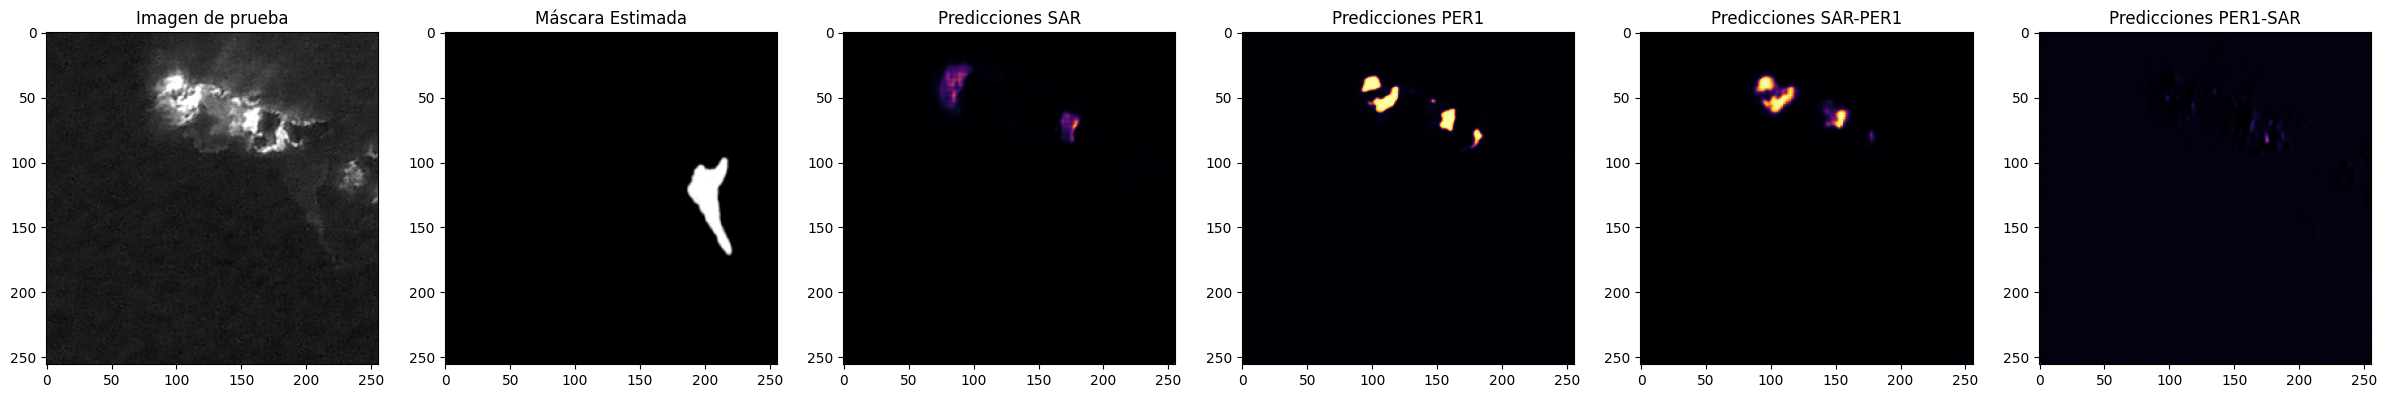

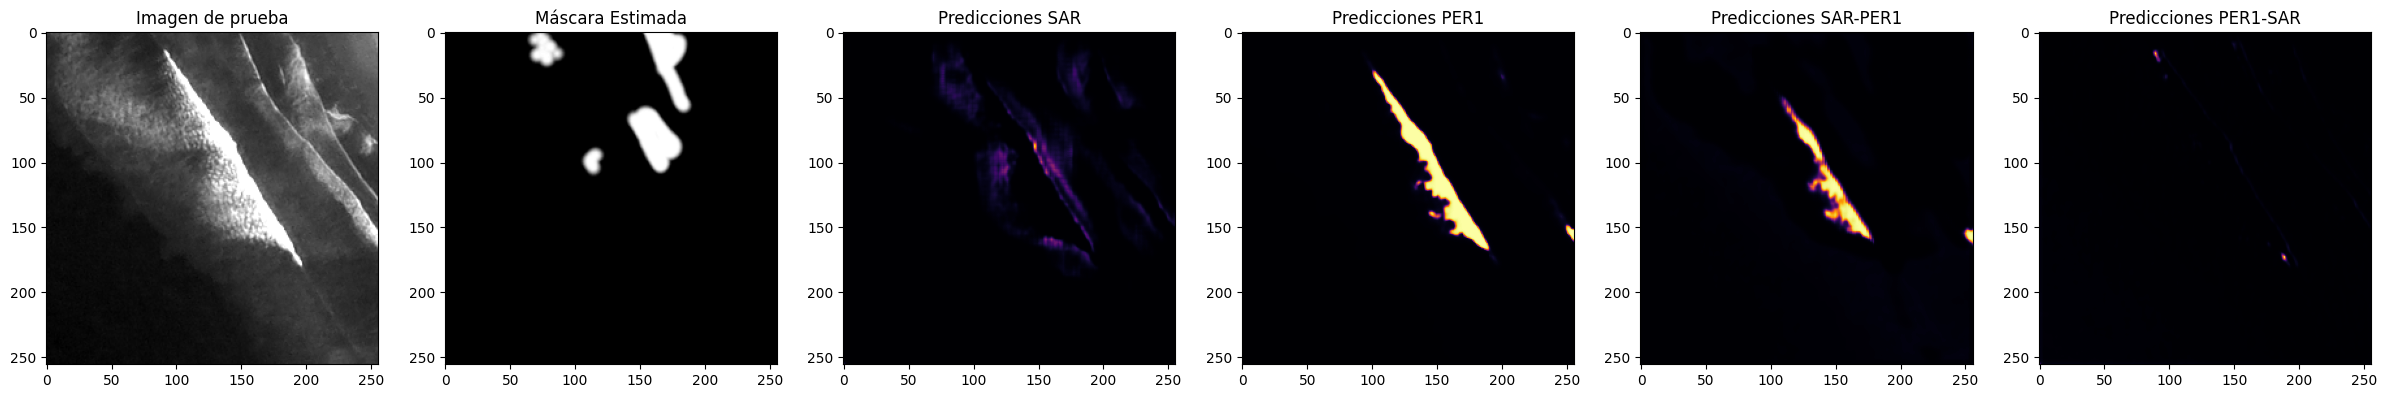

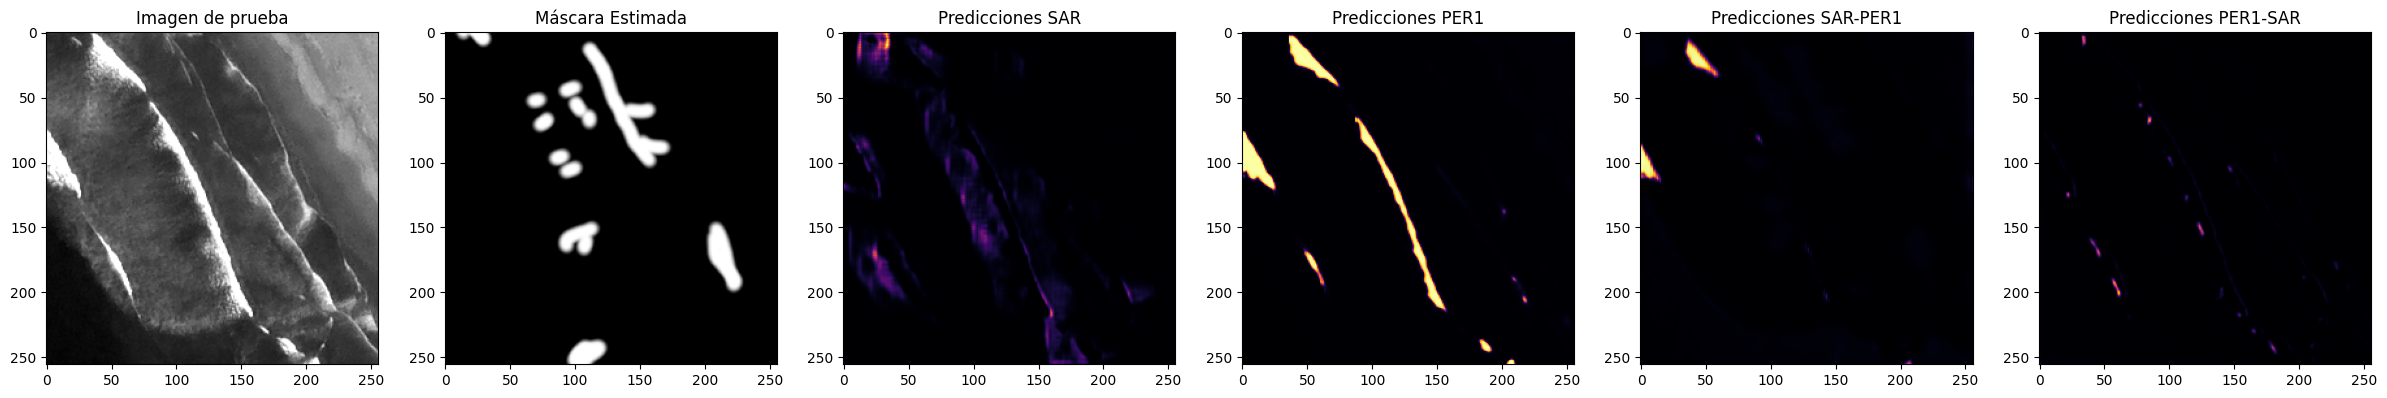

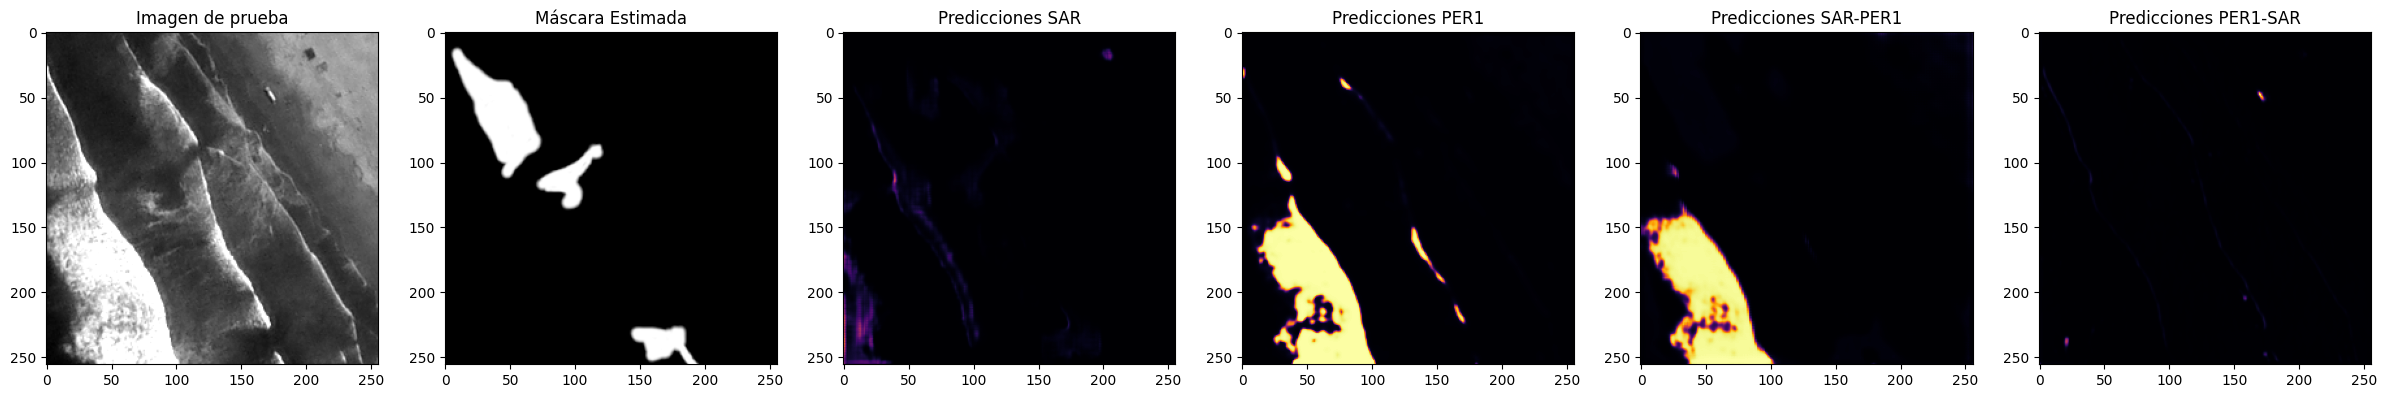

In [7]:

# Ejmplos
test_files = [
    "DS_PER1_20220201OtherCorte1_gray_gray_part30.tif",
    "DS_PER1_20220201OtherCorte1_gray_gray_part21.tif",
    "DS_PER1_20220201OtherCorte1_gray_gray_part4.tif",
    "257290OtherCorte1_gray_gray_part43.tif",
    "257290OtherCorte1_gray_gray_part43.tif"
]

# Lista para almacenar los índices que coinciden con los nombres buscados
test_files_indexs = [index for index, file_name in enumerate(image_files) if file_name in test_files]

# # Imprimimos los índices encontrados
# print("Los índices con nombres de archivo buscados son:", test_files_indexs)
# for i in test_files_indexs:
#     print("El índice", i, "corresponde al archivo", image_files[i])


num_subplots = len(test_files_indexs)

for i in range(num_subplots):
    plt.figure(figsize=(30, 5))
    idx = test_files_indexs[i]
    
    # Imagen de prueba
    plt.subplot(1, 6, 1)
    plt.imshow(test_images[idx].squeeze(), cmap='gray')
    plt.title('Imagen de prueba')
    
    # Máscara real
    plt.subplot(1, 6, 2)
    plt.imshow(test_masks[idx].squeeze(), cmap='gray')
    plt.title('Máscara Estimada')

    # Predicciones del modelo SAR
    plt.subplot(1, 6, 3)
    plt.imshow(predictions_model_SAR[idx].squeeze(), cmap='inferno')
    plt.title('Predicciones SAR')

    # Predicciones del modelo PER1
    plt.subplot(1, 6, 4)
    plt.imshow(predictions_model_PER1[idx].squeeze(), cmap='inferno')
    plt.title('Predicciones PER1')

    # Predicciones del modelo SAR reforzado con el dataset de Perusat1
    plt.subplot(1, 6, 5)
    plt.imshow(predictions_model_SAR_PER1[idx].squeeze(), cmap='inferno')
    plt.title('Predicciones SAR-PER1')

    # Predicciones del modelo PER1 reforzado con el dataset de SAR
    plt.subplot(1, 6, 6)
    plt.imshow(predictions_model_PER1_SAR[idx].squeeze(), cmap='inferno')
    plt.title('Predicciones PER1-SAR')

    plt.show()


## Ejemplo Práctico

1/1 [==============================] - 0s 225ms/step


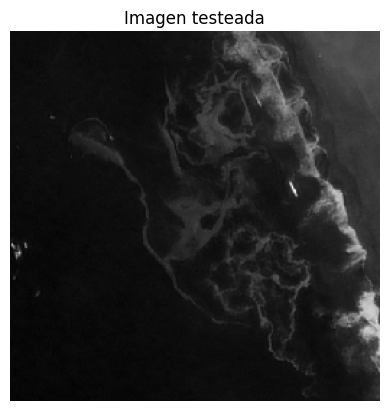

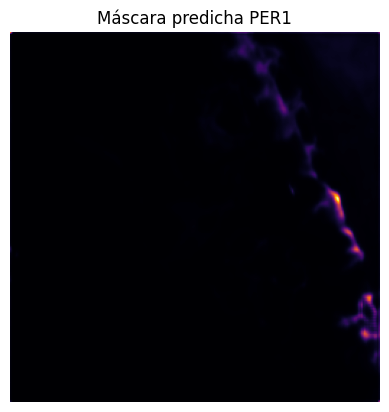

In [8]:


image_path = "ejemplo.png"
test_image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, image_size)
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=0)
test_image = np.expand_dims(test_image, axis=-1)


# Carga modelo
model = tf.keras.models.load_model("./DataSave/models/model_100E_32N_reinforce_E30.h5")
#predecir mascara
predicted_mask= model.predict(test_image) 

# Mostrar la imagen testeada
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Imagen testeada')
plt.axis('off')
plt.show()

#Mostrar la máscara predicha
predicted_mask = predicted_mask.squeeze()
plt.imshow(predicted_mask, cmap='inferno')
plt.title('Máscara predicha PER1')
plt.axis('off')
plt.show()

plt.show()



